In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
raw_data = pd.read_csv('dataset_hackaton_ksg_v2.csv', sep=';', on_bad_lines='skip').drop(columns=['Unnamed: 0', '№ п/п'])
raw_attrs = pd.read_csv('data_mgz_attributes.csv', sep=';').drop(columns=['Unnamed: 0'])

C:\Users\Владимир\AppData\Local\Temp\ipykernel_6836\3047152918.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('dataset_hackaton_ksg_v2.csv', sep=';', on_bad_lines='skip').drop(columns=['Unnamed: 0', '№ п/п'])


In [3]:
def drop_bad_entries(df):
    # Некоторые obj_key не имеют данных о каких-либо задачах, найдём их и выкинем
    objects_to_drop = df.loc[df.ПроцентЗавершенияЗадачи.isna()].obj_key.unique()
    objects_to_drop = df.loc[df.obj_key.isin(objects_to_drop)][['obj_key', 'Кодзадачи']].groupby(['obj_key']).count()
    objects_to_drop = objects_to_drop[objects_to_drop == 0].dropna()
    indexes_to_drop = df.loc[df.obj_key.isin(objects_to_drop.index)].index
    df = df.drop(index=indexes_to_drop)
    return df
    
    

def prepare_data(df):
    df = drop_bad_entries(df)
    df = pd.get_dummies(df, columns=['obj_prg', 'obj_subprg'], drop_first=True)
    df = df.drop(columns=['obj_key', 'НазваниеЗадачи'])
   
    return df

In [4]:
# Переименуем столбец "Код ДС" в "obj_key"
raw_attrs = raw_attrs.rename(columns={'Код ДС' : 'obj_key'})

# Выделим, к какой неделе года относится date_report
raw_attrs['week'] = [str(datetime.date(*list(map(int, attr_date.split('.')))).isocalendar()[1]) for attr_date in raw_attrs.date_report.values]
raw_attrs.date_report = raw_attrs.obj_key + '_' + raw_attrs.week

# Добавляем столбец, показывающий, была ли указана площадь, и зануляем NaN в площади
raw_attrs['is_square'] = raw_attrs['Площадь'].isna()
raw_attrs.Площадь = raw_attrs.Площадь.fillna(0)


raw_attrs['состояние площадки'] = raw_attrs['состояние площадки'].fillna('Не указано')

# Добавляем столбец, показывающий, было ли указано количество рабочих, и зануляем NaN
raw_attrs['is_workers'] = raw_attrs['Кол-во рабочих'].isna()
raw_attrs['Кол-во рабочих'] = raw_attrs['Кол-во рабочих'].fillna(0)

raw_attrs = raw_attrs.set_index('date_report').groupby('date_report').max().drop(columns=['obj_key', 'week'])

In [5]:
raw_data['week'] = [str(datetime.date(*list(map(int, data_date.split('.')))).isocalendar()[1]) for data_date in raw_data.date_report.values]
raw_data['Date_report_and_week'] = raw_data.obj_key + '_' + raw_data.week
raw_data = raw_data.dropna(subset=['ДатаНачалаЗадачи', 'ДатаОкончанияЗадачи'])
raw_data['Статуспоэкспертизе'] = raw_data['Статуспоэкспертизе'].fillna(0)
raw_data['Экспертиза'] = raw_data['Экспертиза'].fillna('0TC')
raw_data['target'] = 0
start_dates = raw_data['ДатаНачалаЗадачи']
end_dates = raw_data['ДатаОкончанияЗадачи']
target = []
for start, end in zip(start_dates, end_dates):
    start_date = datetime.date(*map(int, start.split('-')))
    end_date = datetime.date(*map(int, end.split('-')))
    target.append((end_date - start_date).days)
raw_data['target'] = target
raw_data = raw_data.drop(columns=['obj_prg', 'НазваниеЗадачи', 'ДатаНачалаЗадачи', 'ДатаОкончанияЗадачи', 'ДатаначалаБП0', 'ДатаокончанияБП0'])

In [6]:
dataset = raw_data.join(raw_attrs, on=['Date_report_and_week'], how='inner').drop('Date_report_and_week', axis=1)

In [7]:
dataset.head()

,obj_subprg,obj_key,Кодзадачи,ПроцентЗавершенияЗадачи,Статуспоэкспертизе,Экспертиза,date_report,week,target,состояние площадки,Площадь,Генпроектировщик,Генподрядчик,Кол-во рабочих,is_square,is_workers
0,Общеобразовательные учреждения,022-0527,1,0.0,0.0,0TC,2023.01.17,3,440,Не передана,9850.0,0,0,0.0,False,True
69,Общеобразовательные учреждения,022-0527,1.1,0.0,0.0,0TC,2023.01.17,3,0,Не передана,9850.0,0,0,0.0,False,True
116,Общеобразовательные учреждения,022-0527,1.2,0.0,0.0,0TC,2023.01.17,3,27,Не передана,9850.0,0,0,0.0,False,True
180,Общеобразовательные учреждения,022-0527,1.2.1,0.0,0.0,0TC,2023.01.17,3,0,Не передана,9850.0,0,0,0.0,False,True
215,Общеобразовательные учреждения,022-0527,1.2.2,0.0,0.0,0TC,2023.01.17,3,27,Не передана,9850.0,0,0,0.0,False,True


In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059960 entries, 0 to 1056075
Data columns (total 16 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   obj_subprg               1059960 non-null  object 
 1   obj_key                  1059960 non-null  object 
 2   Кодзадачи                1059960 non-null  object 
 3   ПроцентЗавершенияЗадачи  1059960 non-null  float64
 4   Статуспоэкспертизе       1059960 non-null  float64
 5   Экспертиза               1059960 non-null  object 
 6   date_report              1059960 non-null  object 
 7   week                     1059960 non-null  object 
 8   target                   1059960 non-null  int64  
 9   состояние площадки       1059960 non-null  object 
 10  Площадь                  1059960 non-null  float64
 11  Генпроектировщик         1059960 non-null  int64  
 12  Генподрядчик             1059960 non-null  int64  
 13  Кол-во рабочих           1059960 non-null 

In [9]:
times = dataset.groupby('date_report')['target'].agg(['mean', 'median']) 

In [10]:
weeks = [i + 1 for i in range(len(times.index))]

In [11]:
times['Week'] = weeks

In [12]:
times.head()

,mean,median,Week
date_report,,,
2023.01.17,79.897222,22.0,1
2023.01.23,79.782332,22.0,2
2023.02.06,76.606787,19.0,3
2023.02.13,75.779358,19.0,4
2023.02.20,75.985669,19.0,5


In [13]:
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 0, 'Неделя')

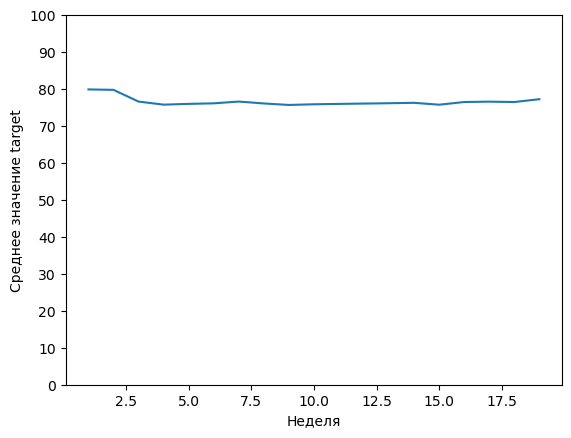

In [14]:
plt.plot(times['Week'], times['mean']) 
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.ylabel('Среднее значение target') 
plt.xlabel('Неделя')

Text(0.5, 0, 'Неделя')

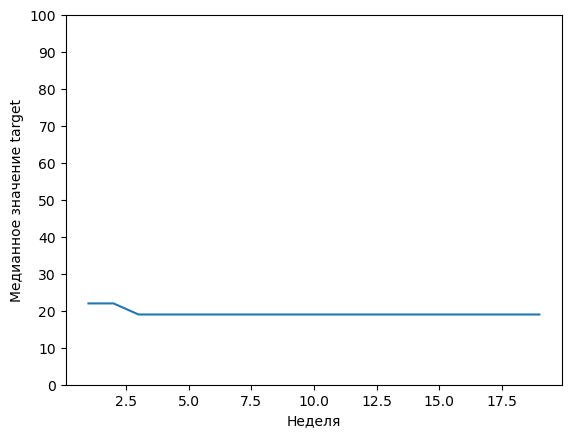

In [15]:
plt.plot(times['Week'], times['median']) 
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
plt.ylabel('Медианное значение target') 
plt.xlabel('Неделя')

## Подготовка данных к обучению

In [16]:
y = dataset['target'].copy()

In [17]:
y.head()

0      440
69       0
116     27
180      0
215     27
Name: target, dtype: int64

In [18]:
X = dataset.drop(columns=['target'])

In [19]:
X.head()

,obj_subprg,obj_key,Кодзадачи,ПроцентЗавершенияЗадачи,Статуспоэкспертизе,Экспертиза,date_report,week,состояние площадки,Площадь,Генпроектировщик,Генподрядчик,Кол-во рабочих,is_square,is_workers
0,Общеобразовательные учреждения,022-0527,1,0.0,0.0,0TC,2023.01.17,3,Не передана,9850.0,0,0,0.0,False,True
69,Общеобразовательные учреждения,022-0527,1.1,0.0,0.0,0TC,2023.01.17,3,Не передана,9850.0,0,0,0.0,False,True
116,Общеобразовательные учреждения,022-0527,1.2,0.0,0.0,0TC,2023.01.17,3,Не передана,9850.0,0,0,0.0,False,True
180,Общеобразовательные учреждения,022-0527,1.2.1,0.0,0.0,0TC,2023.01.17,3,Не передана,9850.0,0,0,0.0,False,True
215,Общеобразовательные учреждения,022-0527,1.2.2,0.0,0.0,0TC,2023.01.17,3,Не передана,9850.0,0,0,0.0,False,True


In [20]:
X.obj_subprg.value_counts()

Общеобразовательные учреждения    446931
Поликлиники                       261871
Дошкольные учреждения             257249
ССК                                93909
Name: obj_subprg, dtype: int64

In [21]:
for i in X.index: 
    if X.loc[i, 'is_square']: 
        X.loc[i, 'is_square'] = 1 
    else: 
        X.loc[i, 'is_square'] = 0 
    if X.loc[i, 'is_workers']: 
        X.loc[i, 'is_workers'] = 1
    else: 
        X.loc[i, 'is_workers'] = 0 

In [22]:
X['Общеобразовательные учреждения'] = 0 
X['Поликлиники'] = 0 
X['Дошкольные учреждения'] = 0 
X['ССК'] = 0 
for i in X.index: 
    X.loc[i, X.loc[i, 'obj_subprg']] = 1 

In [23]:
X['состояние площадки'].value_counts()

Свободна, передана                           549376
Занята                                       208403
Свободна, не передана                        177191
Не указано                                    64633
Не передана                                   58489
Не передана под снос (для объектов сноса)      1628
Передана под снос (для объектов сноса)          240
Name: состояние площадки, dtype: int64

In [25]:
X_new = X.copy()

In [30]:
values = list(X_new['состояние площадки'].unique())
for i in X.index: 
    X_new.loc[i, 'состояние площадки'] = values.index(X_new.loc[i, 'состояние площадки']) + 1

In [31]:
X_new['состояние площадки'].value_counts()

6    549376
3    208403
5    177191
2     64633
1     58489
4      1628
7       240
Name: состояние площадки, dtype: int64

In [41]:
X_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1059960 entries, 0 to 1056075
Data columns (total 19 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   obj_subprg                      1059960 non-null  object 
 1   obj_key                         1059960 non-null  object 
 2   Кодзадачи                       1059960 non-null  object 
 3   ПроцентЗавершенияЗадачи         1059960 non-null  float64
 4   Статуспоэкспертизе              1059960 non-null  float64
 5   Экспертиза                      1059960 non-null  object 
 6   date_report                     1059960 non-null  object 
 7   week                            1059960 non-null  object 
 8   состояние площадки              1059960 non-null  float64
 9   Площадь                         1059960 non-null  float64
 10  Генпроектировщик                1059960 non-null  int64  
 11  Генподрядчик                    1059960 non-null  int64  
 12  

In [40]:
X_new[['is_square', 'is_workers', 'состояние площадки']] = X_new[['is_square', 'is_workers', 'состояние площадки']].astype('float')

In [33]:
from sklearn.model_selection import train_test_split

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y)

In [44]:
X_train.head()

,obj_subprg,obj_key,Кодзадачи,ПроцентЗавершенияЗадачи,Статуспоэкспертизе,Экспертиза,date_report,week,состояние площадки,Площадь,Генпроектировщик,Генподрядчик,Кол-во рабочих,is_square,is_workers,Общеобразовательные учреждения,Поликлиники,Дошкольные учреждения,ССК
401850,Поликлиники,019-0473,4.7.1.3,100.0,0.0,0TC,2023.03.13,11,6.0,11507.82,14,10,0.0,0.0,0.0,0,1,0,0
630844,Поликлиники,019-0471,4.7.6.2,100.0,0.0,0TC,2023.04.10,15,6.0,11500.00,20,8,296.0,0.0,0.0,0,1,0,0
673036,Дошкольные учреждения,022-0518,3.5,0.0,0.0,0TC,2023.04.17,16,3.0,6000.00,0,0,0.0,0.0,1.0,0,0,1,0
896582,ССК,019-0477,3.15.0,100.0,0.0,0TC,2023.05.15,20,6.0,3592.70,16,12,6.0,0.0,0.0,0,0,0,1
844396,Общеобразовательные учреждения,022-0522,3.15.6.13,0.0,0.0,0TC,2023.05.10,19,1.0,13260.00,35,24,0.0,0.0,1.0,1,0,0,0


## Создание модели и оценка точности  

In [36]:
from xgboost import XGBRegressor 

In [48]:
features = ['ПроцентЗавершенияЗадачи',
            'состояние площадки',
            'Площадь', 
            'Генпроектировщик', 
            'Генподрядчик', 
            'Кол-во рабочих',
            'is_square',
            'is_workers', 
            'Общеобразовательные учреждения', 
            'Поликлиники', 
            'Дошкольные учреждения', 
            'ССК']

In [49]:
X_fit = X_train[features]

In [50]:
X_test = X_test[features]

In [51]:
model = XGBRegressor()

In [54]:
model.fit(X_fit, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [55]:
predicts = model.predict(X_test)

In [56]:
from sklearn.metrics import mean_squared_error

In [57]:
mse = mean_squared_error(y_test, predicts)

In [71]:
mse

11047.820564847614

In [72]:
rmse = mse ** 0.5
rmse

105.1086131810691